In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH222

# Studying the solvation shell of ions via Molecular Dynamics Simulations

<div class=warn>
Tasks, where you need to edit the code cells will be shown in similar "blue boxes".
<div/>

**IMPORTANT!!!** Use **Google Chrome** to work on the notebook instead of using Microsoft Explorer. The latter handles the visualisation package incorrectly.

## Content of this notebook

#### Analysing the results

7. Analysing results

In [2]:
import hoomd
import hoomd.md
from scipy.interpolate import interp1d
from matplotlib import pyplot 
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import numpy as np
import ase
import ase.io
from ase.visualize import view
import pytraj as pt
import nglview as nv

_ColormakerRegistry()

# 7. Compute the solvation shells

In order to compute the extent of the solvation shells for both cations and anions ("C" and "Ar" particles, respectively), we start with computing the ions-solvent particles pair correlation functions (PCFs). In particular, we need the C-S and the Ar-S pair correlation functions, where "S" refer to the solvent particles.

Once we have obtained those, we can calculate the coordination number of, e.g., S with respect to C (i.e. on average, how many solvent particles "S" can be found around a cation "C" within a ceartin distance $r_{cut}$) via:

$$
CN_{C-S} = 4\pi \rho \int_0^{r_{cut}} PCF_{C-S} \cdot r^2 \cdot dr
$$

### Calculating the pair correlation functions

You can calculate the pair correlation function ***relative to a particular frame only*** using the function "py_rdf_AB" defined below. This function takes in input the following arguments: 

* **r_A**   = a numpy array containing the positions of the A particles (could be "C", "Ar", "S", or all the particles) 
* **r_B**   = a numpy array containing the positions of the A particles (could be "C", "Ar", "S", or all the particles) 
* **L**   = the length of the box (which is assumed to be square/cubic in 2/3D !!)
* **n_dr** = the number of bins used to construct the distance histogram
* **dim** = the dimensionality of the system (2 or 3 D)

In [3]:
# This function computes the pair correlation function for two groups of particles
# We need as input two arrays of positions for particles A and B

def py_rdf_AB(r_A, r_B, L, n_dr, dim):
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    num_particles_A  = len(r_A)
    num_particles_B  = len(r_B)
    rMax           = L/2.0;
    dr             = rMax/n_dr
    edges          = np.linspace(0., rMax + dr, num=n_dr)
    num_increments = len(edges) - 1
    g              = zeros(num_increments)
    radii          = zeros(num_increments)
    numberDensity_A  = len(r_A) / L**dim
    numberDensity_B  = len(r_B) / L**dim

    # Compute pairwise correlation
    
    # Loop over particles A
    for index in range(num_particles_A):

        d = 0.0
        for i in range(dim):
            
            # (Components of the) distances between each particle A and all the particles B
            dp = absolute(r_A[index,i] - r_B[:,i])
            mask = dp>L/2.0
            dp[mask] = L - dp[mask]
            d += dp*dp

        d = sqrt(d) # array containing the num_particles distances from particle index to all other particles
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g += result

    # Normalise by the number of B particles and the number density for A particles only    
    g = g/(num_particles_B * numberDensity_A)

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 3D
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i])

    return (radii, g)

<div class=warn>
    
* Load the trajectory file (use the filename you want to use!)
    
</div>

How to access different frames within your MD trajectory, and how to access the positions of all the particles within each frame as well as the dimensions of the simulation box for each frame.

In [4]:
# Load the trajectory into the "traj" object:
traj = pt.load('MD_T0.800_p0.100.dcd', top='system.pdb')

# Access the positions of all the particles within a single frame 
# index = 0 is the first frame the simulation started from

# Select the last frame [-1] from the trajectory object traj, this should be an equilibrated liquid configuration
rr = traj[-1]

# .xyz prints out the positions [UNITS?], which we store in the numpy array r
r = np.array(rr.xyz)

# Access the length of the box 
# Note that for a NPT simulation the box will change in time, hence we need to select the box for each frame

# .box.z prints the magnitude of the cell vector aligned with the z axis. 
# As we are using a cubic simulation box (identified via three cell vectors of equal length aligned
# along the x, y and axis), you - could - also use .box.y and .box.x
# NOTE: do - not - use .box.x, though (bug!)
# We store this number in the variable S, which represents the length of the box [in Angstrom]
L = rr.box.z

<div class=warn>
    
* Calculate the pair correlation function *for all the particles in the system* and plot it! (With the default parameters in the cell where you loaded the trajectory, this is going to be the last configuration in the file - this should be an equilibrated liquid. Can you see all the features typical for a liquid RDF?)
    
</div>

In [5]:
n_dr=50

# Compute the g(r). dist contains the distances (x-axis), pcf_all contains the g(r)
dist, pcf_all = py_rdf_AB(r, r, L, n_dr, 3)

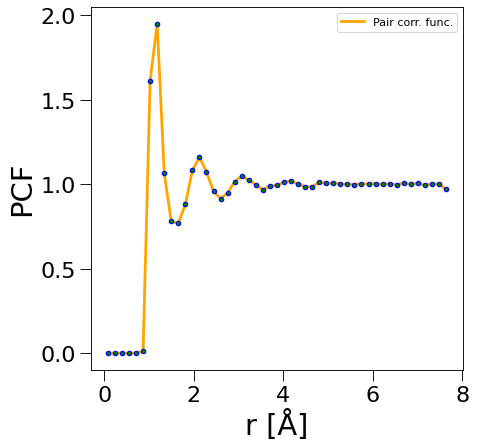

In [6]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Actual g(r) points
plt.plot(dist, pcf_all, '-', color='orange', linewidth=2.5, label='Pair corr. func.')
plt.plot(dist, pcf_all, 'o', markerfacecolor='green', markersize=4, markeredgecolor='blue', 
         linewidth=2.5)

plt.legend()
plt.xlabel('r [Å]', fontsize=26)
plt.ylabel('PCF', fontsize=26)
plt.show()

<div class=warn>
    
* Calculate the C-S and the Ar-S pair correlation function and plot them on the same graph - again, just for the last frame in the trajectory

</div>

We know how to access the positions of *all* the particles in a given frame, but in order to compute the e.g. C-S PCF we need to be able to access the positions of C and S atoms only. Here is how we do it...

In [7]:
# Frame 0
frame = traj[-1]

# Read the topology
top=traj.top

# Get the indexes of the cations
idx_C=top.select('@C')
r_C=[]

for i in idx_C:
    # Fill a list with the positions of the cations only
    r_C.append(frame[i])
    
# Get the indexes of the solvent particles
idx_S=top.select('@S')
r_S=[]

for i in idx_S:
    r_S.append(frame[i])

# Get the corresponding box length to be able to calculate the volume     
L = frame.box.z    

# "Flattening" - that is, we have a list of lists, we need a n_atoms x 3 shaped array...

# C
tmp = np.array([item for subl in r_C for item in subl])
n_C = int(len(tmp)/3)
r_C = tmp.reshape((n_C, 3))

#S
tmp = np.array([item for subl in r_S for item in subl])
n_S = int(len(tmp)/3)
r_S = tmp.reshape((n_S, 3))

Now that we know how to obtain the PCF for any given pair of species for a single configuration/frame of our MD trajectory, we need to take an ensemble average of the PCF across different frames.

<div class=warn>
    
* Calculate the C-S and Ar-S PCFs, this time performing an ensemble average across your MD trajectory (how many frames?)
    
* Identify (by visual inspection) the cutoff radius $r_{cut}$ within which you want to compute the C-S and Ar-S coordination numbers (i.e. the spatial extent of the C-S or Ar-S solvation shell). Typically, one choose the first minimum of the PCF, which in turn sits at distances just a tad bit longer than those for which you observe the most intense peak of the PCF.
    
* Compute the C-S and the Ar-S coordination numbers up to $r_{cut}$. Comment (in a markdown cell) about your results, with sepcific reference to the choice of LJ parameters you have made to describe the interactions in your system.
    
</div>